In [1]:
import pandas as pd
import numpy as np



In [2]:
TOTAL = 'Monthly Mean Total Sunspot Number'
DIFF = 'Sunspot Diff'
df = pd.read_csv("./data/Sunspots.csv")

In [3]:
df.drop(df.columns[0], axis=1, inplace=True)

In [4]:
df['Date'] = pd.to_datetime(df['Date']) #always format the date
df = df.sort_values(['Date'])


In [5]:
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [6]:
# Defining a function to test stationarity
#SOURCE:https://github.com/tklouie/PyData_LA_2018/blob/master/PyData_LA_2018_Tutorial.ipynb

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


def show_moving_statistics(timeseries, window=12):

    # Determing rolling statistics
    rolmean = timeseries.rolling(window = window, center = False).mean()
    rolstd = timeseries.rolling(window = window, center = False).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color = 'blue',label = 'Original')
    mean = plt.plot(rolmean, color = 'red',label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for Sunspots')
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()


In [7]:
# https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [8]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

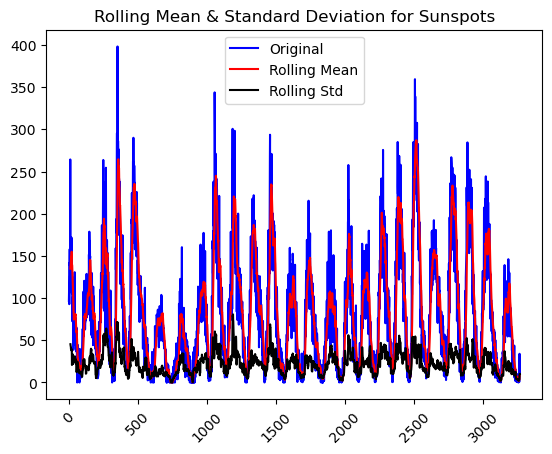

Results of Dickey-Fuller Test:
Test Statistic                -1.049705e+01
p-value                        1.108552e-18
#Lags Used                     2.800000e+01
Number of Observations Used    3.236000e+03
Critical Value (1%)           -3.432372e+00
Critical Value (5%)           -2.862434e+00
Critical Value (10%)          -2.567246e+00
dtype: float64
Results of KPSS Test:
Test Statistic            0.103805
p-value                   0.100000
Lags Used                36.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\piotr\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [9]:
show_moving_statistics(df[TOTAL])
adf_test(df[TOTAL])
kpss_test(df[TOTAL])

## Z powyższego wynika, że dane są stacjonarne

In [10]:
df[DIFF] = df[TOTAL] - df[TOTAL].shift(
    1
)

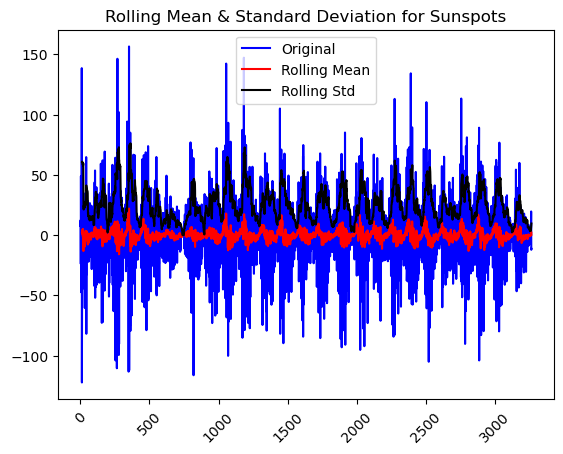

Results of Dickey-Fuller Test:
Test Statistic                -9.110773e+00
p-value                        3.404382e-15
#Lags Used                     2.800000e+01
Number of Observations Used    3.235000e+03
Critical Value (1%)           -3.432373e+00
Critical Value (5%)           -2.862434e+00
Critical Value (10%)          -2.567246e+00
dtype: float64
Results of KPSS Test:
Test Statistic            0.007336
p-value                   0.100000
Lags Used                36.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\piotr\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [11]:
show_moving_statistics(df[DIFF].dropna())
adf_test(df[DIFF].dropna())
kpss_test(df[DIFF].dropna())

## Tu są jeszcze bardziej stacjonarne

In [12]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [13]:
n_steps_in, n_steps_out = 24, 1



In [14]:
test_frac = 0.1
X = df[TOTAL]

test_obs =  int(np.round(test_frac*len(X)))
test_df = np.array(X)[-test_obs:]
train_df = np.array(X)[:-test_obs]

train_X, train_y = split_sequence(train_df, n_steps_in, n_steps_out)

In [15]:
test_obs

326

In [16]:
train_X.shape, train_y.shape

((2915, 24), (2915, 1))

In [42]:
# https://towardsdatascience.com/predicting-stock-prices-with-echo-state-networks-f910809d23d4
from pyESN import ESN

esn = ESN(n_inputs = 24,
          n_outputs = 1,
          n_reservoir = 500,
          sparsity=0.2,
          random_state=23,
          spectral_radius=1.2,
          noise = 0.005)

esn.fit(train_X, train_y)



array([[130.9937011 ],
       [127.90780941],
       [ 94.27695563],
       ...,
       [ 74.14087081],
       [ 47.43006888],
       [ 69.41024717]])

In [43]:
predictions = np.array([])
window = train_X[-1].reshape((1,-1))

for i in range(test_obs):
    prediction = esn.predict(window)
    window = np.concatenate((window[:,1:],  prediction), axis=1)
    predictions = np.append(predictions, prediction[0,0])

In [44]:
train_X[-1]

array([159.5, 212.6, 198.3, 230.7, 151. , 142.2,  94.3,  98.5, 114.2,
        91.9,  94. , 133.4, 129.6, 122. ,  81.4, 127.8, 102.4,  94.4,
        78.8,  69.6,  80.4,  62.5,  31.2,  71.1])

In [47]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_df[:50], predictions[:50])
mse

215.16518832479917

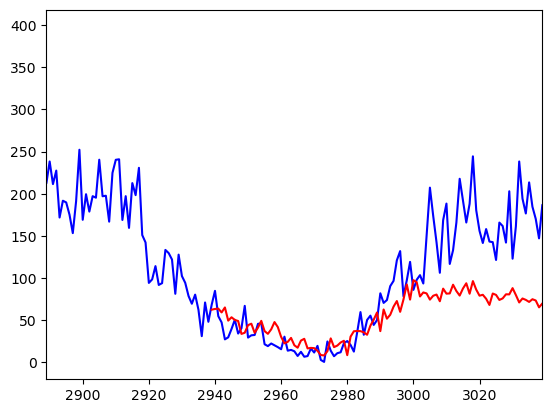

In [48]:
plt.plot(X, color = 'blue', label = 'Original')
plt.plot(range(len(X)-test_obs, len(X)), predictions, color = 'red',label = 'Rolling Mean')
plt.xlim((len(X)-test_obs-50, len(X)-test_obs+100))
plt.show()